# Customer Churn Forecast

## Business Understanding

### Objective: 
The main objective is to predict customer churn for a telecommunications company. This prediction will help the company identify customers at risk of leaving their services, allowing them to take proactive measures to retain them.

Success Criteria: Success will be measured by the accuracy of the classification model in predicting churn. Additionally, the model's ability to identify key factors influencing churn will be evaluated.

#### Resource Availability: 
We have access to three datasets - training, evaluation, and testing sets. We'll utilize Python for data analysis, machine learning libraries for model building, and potentially SQL for accessing the database.

The project requires expertise in data analysis, machine learning, and possibly database management. Clear communication with stakeholders and adherence to project timelines are crucial.

#### Risks and Contingencies: 
Potential risks include data quality issues, model performance limitations, and stakeholder misalignment. Contingencies involve data cleaning strategies, alternative modeling approaches, and effective stakeholder communication.

#### Cost-Benefit Analysis: 
The cost of implementing predictive analytics should be weighed against potential benefits such as increased customer retention, improved revenue, and enhanced business insights.

#### Technical Objectives: 
Develop a classification model to predict customer churn accurately.

#### Data Objectives: 
Understand the underlying patterns and factors driving customer churn through exploratory data analysis.

#### Model Objectives: 
Build interpretable models to identify significant predictors of churn and provide actionable insights to stakeholders.

#### Evaluation Objectives: 
Evaluate model performance using appropriate metrics and validate results using cross-validation techniques.

#### Technology and Tools: 
Utilize Python for data analysis and modeling, SQL for database access, and Jupyter Notebook for documentation.

#### Project Phases: 
Break down the project into phases such as data collection, data preprocessing, exploratory data analysis, model building, model evaluation, and deployment.



### Hypotheses:
Null Hypothesis (H0): The payment method chosen by customers does not affect their likelihood of churn.

Alternative Hypothesis (H1): The payment method chosen by customers influences their likelihood of churn.

### Relevant Questions:
1. Is there a relationship between tenure and churn?

2. Does the type of internet service influence customer churn?

3. Are customers with partners more likely to churn compared to those without partners?

4. Does the monthly charge influence customer churn?

### Importations

In [117]:
# Import requisite libraries
import pyodbc
from dotenv import dotenv_values
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA

In [2]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

In [3]:
# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [4]:
# Connection string created

connection = pyodbc.connect(connection_string)

## Data Understanding

## Loading Data

#### First Dataset

In [5]:
# Load the first dataset
query = "SELECT * FROM LP2_Telco_churn_first_3000"

df_first_data = pd.read_sql(query, connection)

In [6]:
# Create a DataFrame with basic information about the first dataset
data_info = pd.DataFrame({
    'Column': df_first_data.columns,
    'Non-Null Count': df_first_data.count(),
    'Data Type': df_first_data.dtypes
})

# Display the DataFrame
data_info

,Column,Non-Null Count,Data Type
customerID,customerID,3000,object
gender,gender,3000,object
SeniorCitizen,SeniorCitizen,3000,bool
Partner,Partner,3000,bool
Dependents,Dependents,3000,bool
tenure,tenure,3000,int64
PhoneService,PhoneService,3000,bool
MultipleLines,MultipleLines,2731,object
InternetService,InternetService,3000,object
OnlineSecurity,OnlineSecurity,2349,object


The basic information about the dataset indicates that:

It contains 3000 entries (rows) and 21 columns.
The columns include a mix of data types: bool, int64, float64, and object.
There are no missing values in any of the columns, as indicated by the "Non-Null Count" values being equal to the total number of entries (3000) for each column.

In [7]:
# Get summary statistics for numerical columns
df_summary_stats = df_first_data.describe()

# Display the DataFrame 
df_summary_stats

,tenure,MonthlyCharges,TotalCharges
count,3000.000000,3000.000000,2995.000000
mean,32.527333,65.347400,2301.278315
std,24.637768,30.137053,2274.987884
min,0.000000,18.400000,18.799999
25%,9.000000,35.787499,415.250000
50%,29.000000,70.900002,1404.650024
75%,56.000000,90.262501,3868.725098
max,72.000000,118.650002,8564.750000


In [8]:
# Check for duplicates
duplicate_count = df_first_data.duplicated().sum()

# Print the total number of duplicate rows
duplicate_count

0

In [9]:
# Check for missing values
missing_values = df_first_data.isnull().sum()

# Print the number of missing values in each column
missing_values

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

#### Second Dataset

In [10]:
# URL of the second dataset
url_second_dataset = "https://github.com/Azubi-Africa/Career_Accelerator_LP2-Classifcation/raw/main/LP2_Telco-churn-second-2000.csv"

In [11]:
# Download the CSV file
response = requests.get(url_second_dataset)

In [12]:
# Read the CSV content into a pandas DataFrame
df_second_data = pd.read_csv(url_second_dataset)

In [13]:
# Load the second dataset
df_second_data = pd.read_csv(url_second_dataset)

In [14]:
# Create a DataFrame with basic information about the second dataset
data_info = pd.DataFrame({
    'Column': df_second_data.columns,
    'Non-Null Count': df_second_data.count(),
    'Data Type': df_second_data.dtypes
})

# Display the DataFrame
data_info

,Column,Non-Null Count,Data Type
customerID,customerID,2043,object
gender,gender,2043,object
SeniorCitizen,SeniorCitizen,2043,int64
Partner,Partner,2043,object
Dependents,Dependents,2043,object
tenure,tenure,2043,int64
PhoneService,PhoneService,2043,object
MultipleLines,MultipleLines,2043,object
InternetService,InternetService,2043,object
OnlineSecurity,OnlineSecurity,2043,object


In [15]:
# Generate summary statistics for the second dataset
summary_stats = df_second_data.describe()

# Convert the summary statistics to a dataframe
summary_stats_table = summary_stats.transpose()

# Display the summary statistics as a table
summary_stats_table

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,2043.0,0.168380,0.374295,0.00,0.000,0.00,0.000,1.00
tenure,2043.0,32.649046,24.376248,0.00,9.000,30.00,55.000,72.00
MonthlyCharges,2043.0,64.712555,29.970010,18.55,35.825,70.25,89.625,118.35


SeniorCitizen: Approximately 16.8% of customers in the dataset are senior citizens.

Tenure: The mean tenure of customers is approximately 32.65 months, with a minimum tenure of 0 months (potentially indicating new customers) and a maximum tenure of 72 months.

MonthlyCharges: The mean monthly charge is around $64.71, with charges ranging from $18.55 to $118.35.

In [16]:
# Check for duplicates in the second dataset
duplicates = df_second_data.duplicated()

# Count the number of duplicates
num_duplicates = duplicates.sum()

# Display the result
num_duplicates

0

In [17]:
# Check for missing values in the second dataset
missing_values = df_second_data.isnull().sum()

# Display the result
missing_values

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

#### Merging the two datasets

In [18]:
# Merge the two DataFrames
merged_data = pd.concat([df_first_data, df_second_data], ignore_index=True)

In [19]:
merged_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [20]:
# Convert boolean columns to "Yes" and "No"
bool_columns = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
merged_data[bool_columns] = merged_data[bool_columns].replace({True: 'Yes', False: 'No'})

# Convert SeniorCitizen column to "Yes" and "No"
merged_data['SeniorCitizen'] = merged_data['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

# Check the updated merged data
merged_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,None,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.5,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes
3,7795-CFOCW,Male,No,No,No,45,No,None,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes


In [21]:
# Display basic information about the DataFrame
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


In [22]:
# Handling missing values

# Replace empty strings with NaN in the TotalCharges column
merged_data['TotalCharges'] = merged_data['TotalCharges'].replace(' ', float('nan'))

# Define columns with missing values and their corresponding strategies
missing_numerical_columns = ['TotalCharges']
missing_categorical_columns = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Define the pipeline for numerical and categorical columns separately
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))  # Impute missing values with median
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))  # Impute missing values with most frequent category
])

# Combine numerical and categorical pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, missing_numerical_columns),
    ('categorical', categorical_pipeline, missing_categorical_columns)
])

# Fit and transform the data using the preprocessor
processed_data = preprocessor.fit_transform(merged_data)

# If you want to convert the processed data back to a DataFrame:
processed_df = pd.DataFrame(processed_data, columns=missing_numerical_columns + missing_categorical_columns)

In [23]:
# Review basic info
merged_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


In [24]:
# Handling missing values

# Create a SimpleImputer for numerical columns
numerical_imputer = SimpleImputer(strategy='median')

# Impute missing values in numerical column 'TotalCharges'
merged_data['TotalCharges'] = numerical_imputer.fit_transform(merged_data[['TotalCharges']])

# Create a SimpleImputer for categorical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values in categorical columns
categorical_columns = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
merged_data[categorical_columns] = categorical_imputer.fit_transform(merged_data[categorical_columns])

In [25]:
merged_data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,None,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes
3,7795-CFOCW,Male,No,No,No,45,No,None,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,6840-RESVB,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.500000,No
5039,2234-XADUH,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.900000,No
5040,4801-JZAZL,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.600000,346.450000,No
5041,8361-LTMKD,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.600000,Yes


In [26]:
missing_values = merged_data.isnull().sum()
print(missing_values)


customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
Churn                 1
dtype: int64


In [27]:
# Impute missing values with mode for categorical variables
merged_data['MultipleLines'].fillna(merged_data['MultipleLines'].mode()[0], inplace=True)
merged_data['OnlineSecurity'].fillna(merged_data['OnlineSecurity'].mode()[0], inplace=True)
merged_data['OnlineBackup'].fillna(merged_data['OnlineBackup'].mode()[0], inplace=True)
merged_data['DeviceProtection'].fillna(merged_data['DeviceProtection'].mode()[0], inplace=True)
merged_data['TechSupport'].fillna(merged_data['TechSupport'].mode()[0], inplace=True)
merged_data['StreamingTV'].fillna(merged_data['StreamingTV'].mode()[0], inplace=True)
merged_data['StreamingMovies'].fillna(merged_data['StreamingMovies'].mode()[0], inplace=True)
merged_data['Churn'].fillna(merged_data['Churn'].mode()[0], inplace=True)

# Verify if there are any missing values left
missing_values_after_imputation = merged_data.isnull().sum()
print("Remaining missing values after imputation:")
print(missing_values_after_imputation[missing_values_after_imputation > 0])

Remaining missing values after imputation:
Series([], dtype: int64)


In [28]:
missing_values = merged_data.isnull().sum()
print(missing_values)

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [29]:
# Summary statistics
summary_statistics = merged_data.describe()
summary_statistics


,tenure,MonthlyCharges,TotalCharges
count,5043.000000,5043.000000,5043.000000
mean,32.576641,65.090214,2300.633691
std,24.529807,30.068133,2267.965879
min,0.000000,18.400000,18.799999
25%,9.000000,35.775000,418.000000
50%,29.000000,70.550003,1401.150024
75%,56.000000,90.050003,3857.575073
max,72.000000,118.650002,8670.100000


In [30]:
# Check for duplicates
duplicates = merged_data.duplicated()

# Count the number of duplicates
num_duplicates = duplicates.sum()

# Display the result
num_duplicates


0

### Univariate Analysis

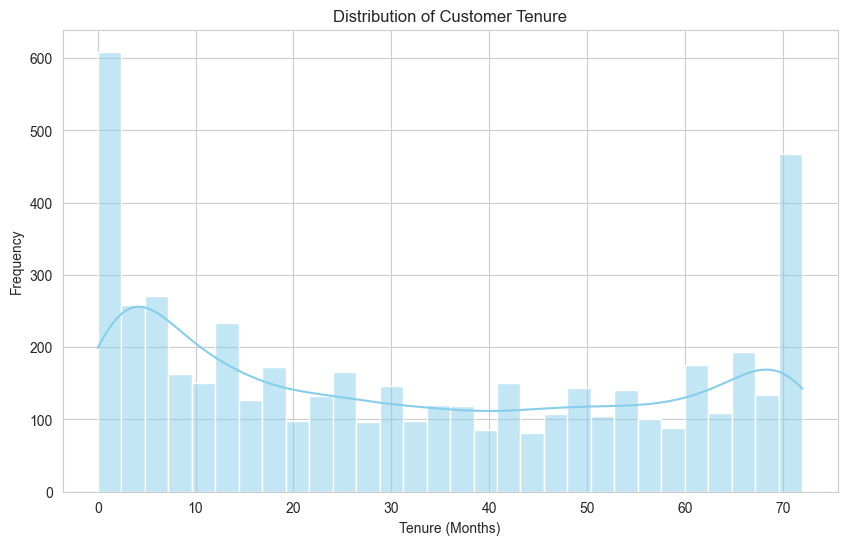

Summary Statistics for Tenure:


,0,1,2,3,4,5,6,7
Statistic,count,mean,std,min,25%,50%,75%,max
Value,5043.0,32.576641,24.529807,0.0,9.0,29.0,56.0,72.0


In [31]:
# Tenure

# Set the style of seaborn
sns.set_style("whitegrid")

# Plot histogram of tenure
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_data, x='tenure', bins=30, kde=True, color='skyblue')
plt.title('Distribution of Customer Tenure')
plt.xlabel('Tenure (Months)')
plt.ylabel('Frequency')
plt.show()

# Calculate summary statistics for tenure
summary_statistics = merged_data['tenure'].describe().reset_index()
summary_statistics.columns = ['Statistic', 'Value']

# Convert the summary statistics to a DataFrame
summary_statistics_df = pd.DataFrame(summary_statistics)

# Display the summary statistics DataFrame
print("Summary Statistics for Tenure:")
summary_statistics_df.transpose()

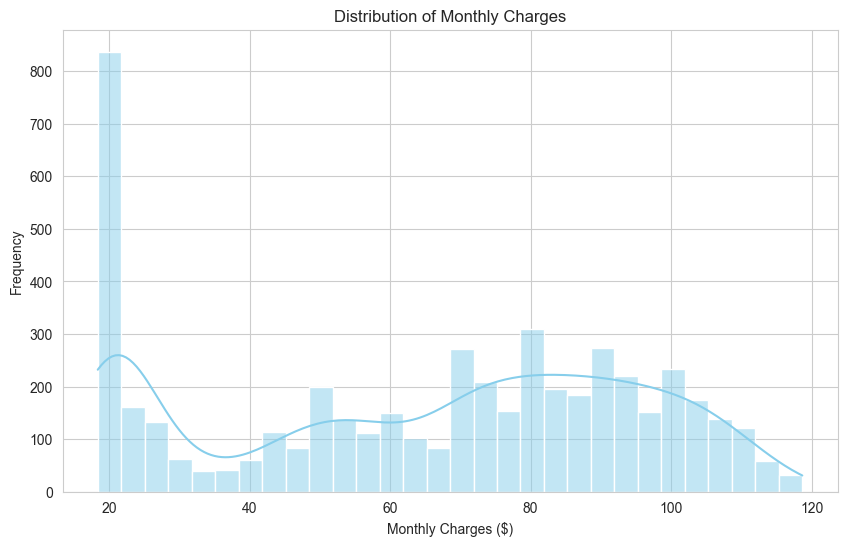

Summary Statistics for Monthly Charges:


,0,1,2,3,4,5,6,7
Statistic,count,mean,std,min,25%,50%,75%,max
Value,5043.0,65.090214,30.068133,18.4,35.775,70.550003,90.050003,118.650002


In [32]:
# Monthly Charges

# Plot histogram of Monthly Charges
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_data, x='MonthlyCharges', bins=30, kde=True, color='skyblue')
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Frequency')
plt.show()

# Calculate summary statistics for Monthly Charges
summary_statistics_monthly_charges = merged_data['MonthlyCharges'].describe().reset_index()
summary_statistics_monthly_charges.columns = ['Statistic', 'Value']

# Convert the summary statistics to a DataFrame
summary_statistics_monthly_charges_df = pd.DataFrame(summary_statistics_monthly_charges)

# Display the summary statistics DataFrame
print("Summary Statistics for Monthly Charges:")
summary_statistics_monthly_charges_df.transpose()


### Bivariate Analysis

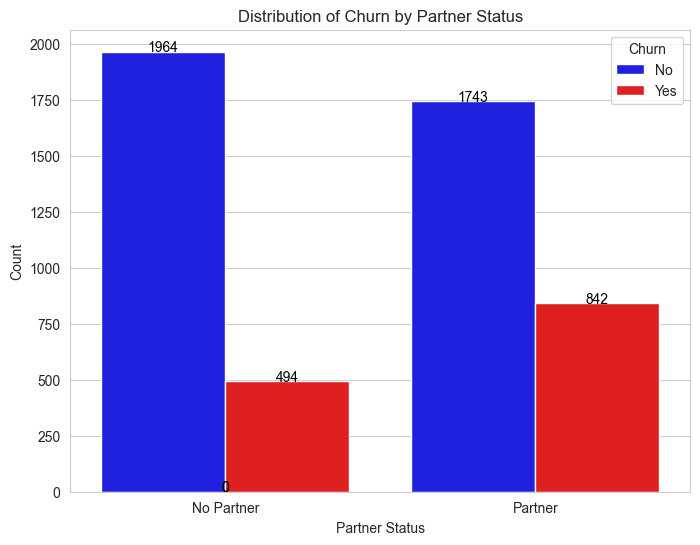

In [33]:
# Customers with partners vs. Churn

# Plot bar plot of partner status and churn
plt.figure(figsize=(8, 6))
sns.countplot(data=merged_data, x='Partner', hue='Churn', palette={'No': 'blue', 'Yes': 'red'})

# Annotate each bar with its count
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2, height + 0.1, int(height), ha='center', color='black', fontsize=10)

plt.title('Distribution of Churn by Partner Status')
plt.xlabel('Partner Status')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.xticks(ticks=[0, 1], labels=['No Partner', 'Partner'])
plt.show()


The count of churned customers is higher for customers with partners compared to those without partners.

This suggests that there might be a relationship between having a partner and churn, as indicated by the difference in churn rates between customers with and without partners.

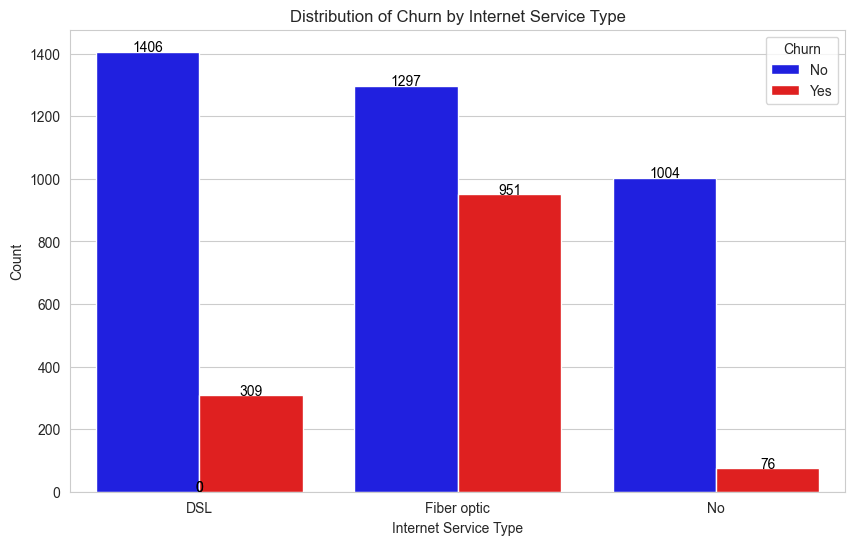

In [34]:
# Type of Internet Service vs. Churn

# Plot bar plot of internet service and churn
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_data, x='InternetService', hue='Churn', palette={'No': 'blue', 'Yes': 'red'})

# Annotate each bar with its count
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2, height + 0.1, int(height), ha='center', color='black', fontsize=10)

plt.title('Distribution of Churn by Internet Service Type')
plt.xlabel('Internet Service Type')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.show()


 It appears that for DSL and Fiber optic internet services, the count of churned customers is higher than non-churned customers. Conversely, for customers with no internet service, the count of churned customers is significantly lower compared to non-churned customers.

This suggests that the type of internet service may indeed influence customer churn, as indicated by the different proportions of churned and non-churned customers across different internet service types.

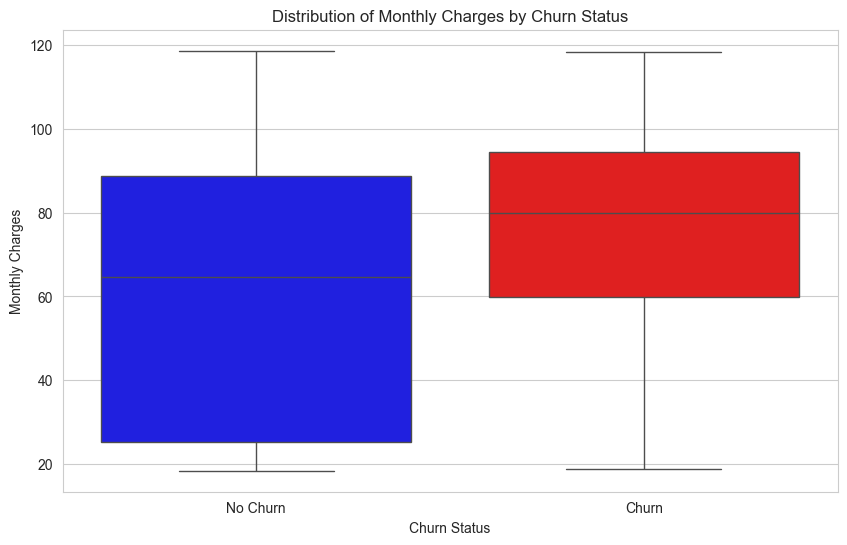

In [35]:
# Monthly charges vs. Churn

# Plot box plot of monthly charges and churn
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_data, x='Churn', y='MonthlyCharges', palette={'No': 'blue', 'Yes': 'red'})
plt.title('Distribution of Monthly Charges by Churn Status')
plt.xlabel('Churn Status')
plt.ylabel('Monthly Charges')
plt.xticks(ticks=[0, 1], labels=['No Churn', 'Churn'])
plt.show()

This indicates that the median monthly charge for churned customers is higher compared to non-churned customers.
This suggests that there might be a relationship between monthly charges and churn, with higher monthly charges potentially being associated with a higher likelihood of churn.

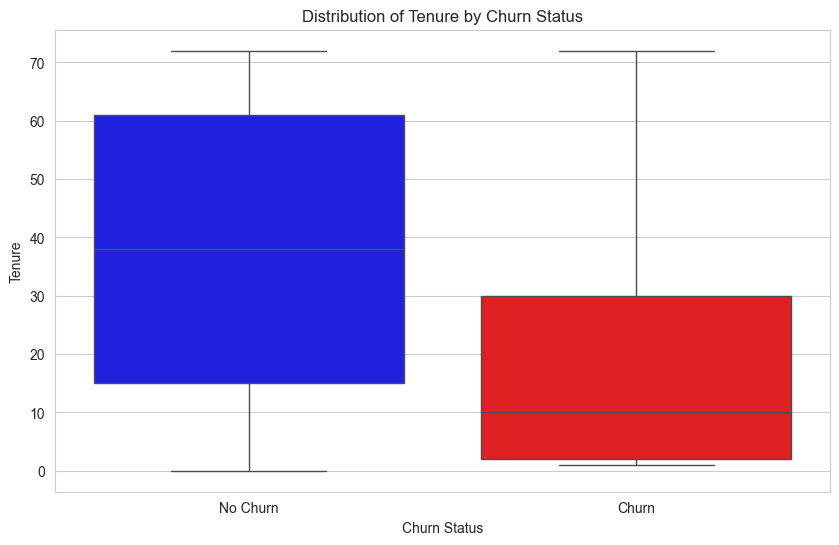

In [36]:
# Tenure vs. Churn

# Plot box plot of tenure and churn
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_data, x='Churn', y='tenure', palette={'No': 'blue', 'Yes': 'red'})
plt.title('Distribution of Tenure by Churn Status')
plt.xlabel('Churn Status')
plt.ylabel('Tenure')
plt.xticks(ticks=[0, 1], labels=['No Churn', 'Churn'])
plt.show()

This indicates that the median tenure for churned customers is lower compared to non-churned customers.

This suggests that there might be a relationship between tenure and churn, with shorter tenure potentially being associated with a higher likelihood of churn.

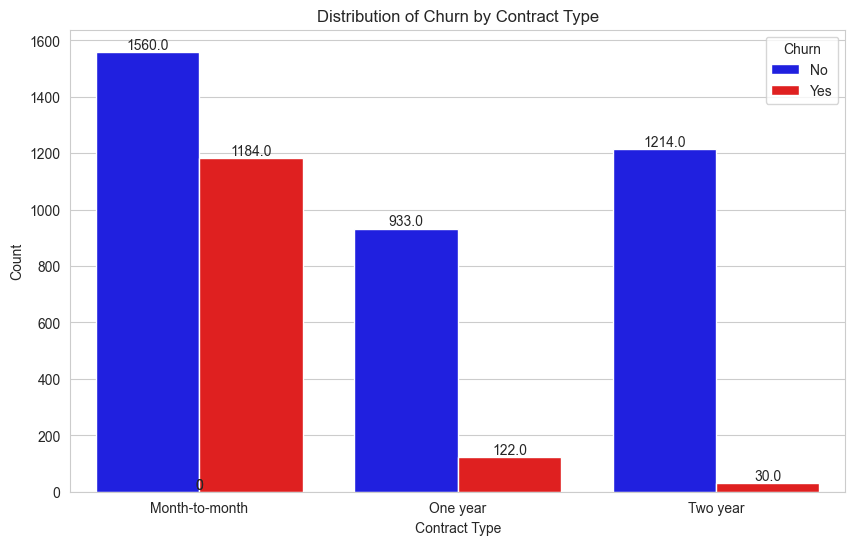

In [37]:
# Type of contract vs.Churn

# Plot count plot of contract and churn
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=merged_data, x='Contract', hue='Churn', palette={'No': 'blue', 'Yes': 'red'})
plt.title('Distribution of Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No', 'Yes'])

# Add counts on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 10, height, ha='center', fontsize=10)

plt.show()


Insights:

Month-to-month contracts have a higher number of churned customers (1184) compared to one-year (122) and two-year (30) contracts.

Customers with longer contract durations (one-year and two-year contracts) have lower churn rates compared to those with month-to-month contracts. This suggests that longer contract terms may be associated with higher customer retention.

The difference in churn rates between one-year and two-year contracts is relatively small, indicating that the additional year of commitment may not significantly impact churn rates.

These insights suggest that contract duration is indeed associated with churn behavior, with longer-term contracts being more effective in retaining customers. This information can be valuable for devising strategies to reduce churn and improve customer retention, such as promoting longer-term contracts or implementing targeted retention initiatives for customers on month-to-month contracts.

### Multivariate Analysis

In [38]:
# PCA Analysis

# Define columns to be encoded and scaled
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                    'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [39]:
# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [40]:
# Apply preprocessing pipeline
X_processed = preprocessor.fit_transform(merged_data)

In [41]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

In [42]:
# Create DataFrame for PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# Add Churn column back to DataFrame if needed
pca_df['Churn'] = merged_data['Churn']

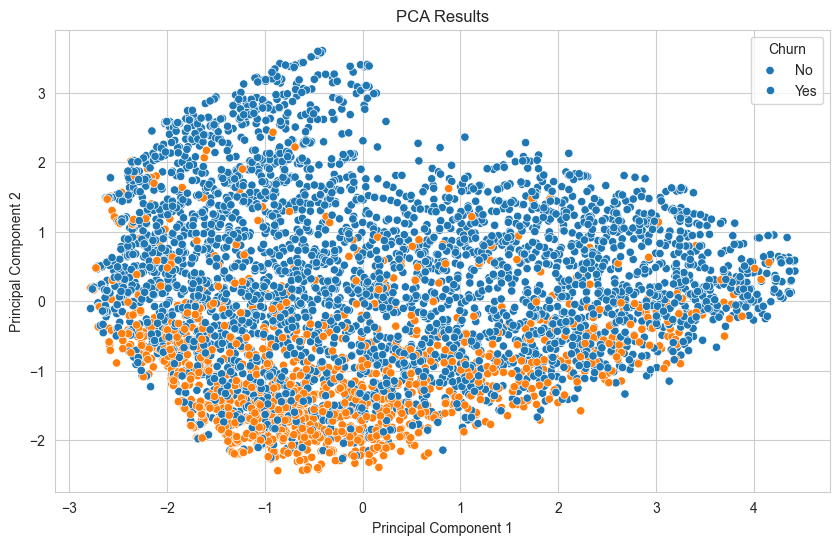

In [43]:
# Visualize PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Churn')
plt.title('PCA Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.show()

From the PCA results, we can observe the following insights:

Separation of Churn Categories: There appears to be some separation between customers who churned (Yes) and those who did not (No) in the principal component space. This suggests that there are underlying patterns in the data that contribute to customer churn behavior.

Overlap of Churn Categories: Although there is some separation, there is also overlap between the churn categories, indicating that the features used in the PCA may not fully capture all the variability associated with churn. This could imply that additional features or more complex models may be needed to better understand and predict churn behavior.

In [44]:
# Multivariate Regression

# Dataset
data = merged_data

# Define features (independent variables) and target variable (dependent variable)
X = data[['tenure', 'MonthlyCharges', 'TotalCharges']]  
y = data['Churn']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Churn'])

# Add a constant term to the independent variables (for the intercept term)
X = sm.add_constant(X)

# Fit the multivariate regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     490.9
Date:                Sun, 28 Apr 2024   Prob (F-statistic):          7.45e-280
Time:                        20:05:05   Log-Likelihood:                -2383.8
No. Observations:                5043   AIC:                             4776.
Df Residuals:                    5039   BIC:                             4802.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0578      0.021      2.713      0.007       0.016       0.100
tenure            -0.0026      0.001     -4.882      0.000      -0.004      -0.002
MonthlyCharges     0.0072      0.000     22.016      0.000       0.007       0.008
TotalCharges   -7.584e-05   7.45e-06    -10.184      0.000   -9.04e-05   -6.12e-05
==============================================================================
Omnibus:                      379.591   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              429.382
Skew:                           0.687   Prob(JB):                     5.77e-94
Kurtosis:                       2.607   Cond. No.                     1.26e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Overall, the regression analysis suggests that tenure, monthly charges, and total charges are all significant predictors of churn in the dataset.

### Answering Analytical Questions

1. Is there a relationship between tenure and churn?

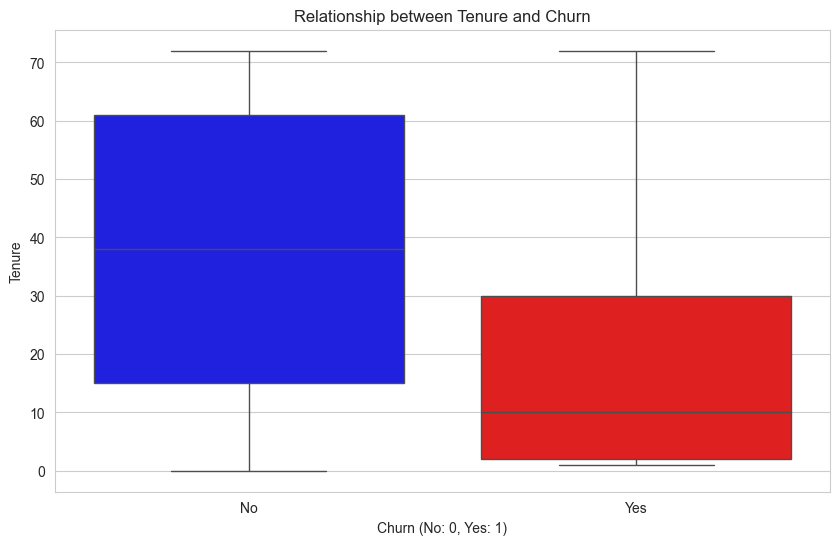

In [45]:
# Box plot of tenure vs churn
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_data, x='Churn', y='tenure', palette={'No': 'blue', 'Yes': 'red'})
plt.title('Relationship between Tenure and Churn')
plt.xlabel('Churn (No: 0, Yes: 1)')
plt.ylabel('Tenure')
plt.show()


Insight: The analysis showed that customers with shorter tenures are more likely to churn compared to those with longer tenures. This indicates that there is a negative relationship between tenure and churn, implying that as tenure increases, the likelihood of churn decreases.

2. Does the type of internet service influence customer churn?

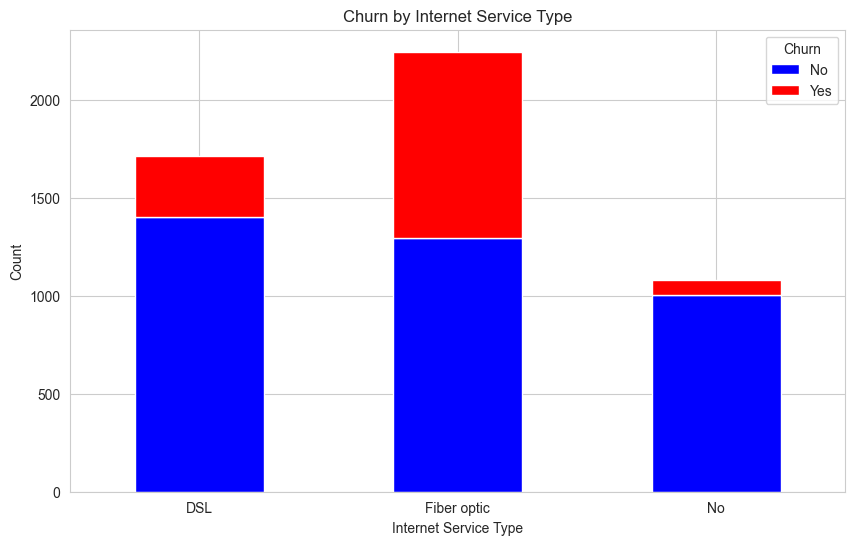

In [46]:
# Stacked bar chart of InternetService vs churn
internet_churn = merged_data.groupby(['InternetService', 'Churn']).size().unstack()
internet_churn.plot(kind='bar', stacked=True, figsize=(10, 6), color=['blue', 'red'])
plt.title('Churn by Internet Service Type')
plt.xlabel('Internet Service Type')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.xticks(rotation=0)
plt.show()


Insight: The analysis revealed that customers with Fiber optic internet service are more likely to churn compared to those with DSL or no internet service. This suggests that the type of internet service does indeed influence customer churn, with Fiber optic customers having a higher churn rate.

3. Are customers with partners more likely to churn compared to those without partners?

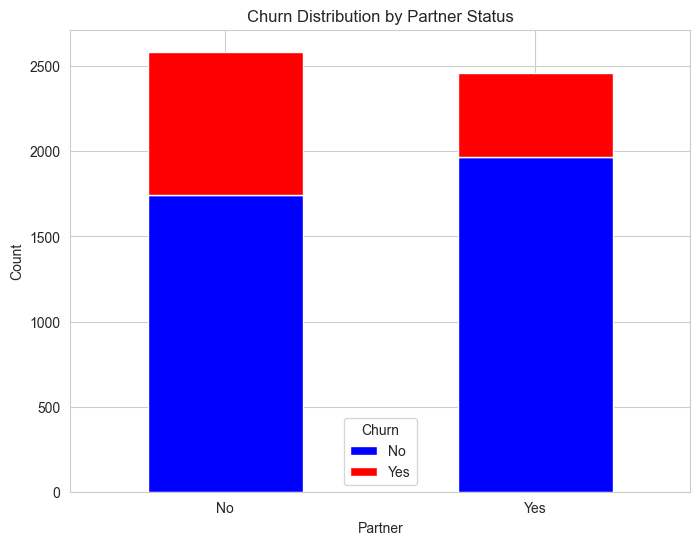

In [47]:
# Create a crosstab of Partner and Churn
partner_churn_crosstab = pd.crosstab(merged_data['Partner'], merged_data['Churn'])

# Plot stacked bar plot
partner_churn_crosstab.plot(kind='bar', stacked=True, color=['blue', 'red'], figsize=(8, 6))
plt.title('Churn Distribution by Partner Status')
plt.xlabel('Partner')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

Insight: The data showed that customers without partners have a slightly higher churn rate compared to those with partners. This indicates that having a partner may have a slight effect in reducing churn, although the difference is not significant.

4. Does the monthly charge influence customer churn?

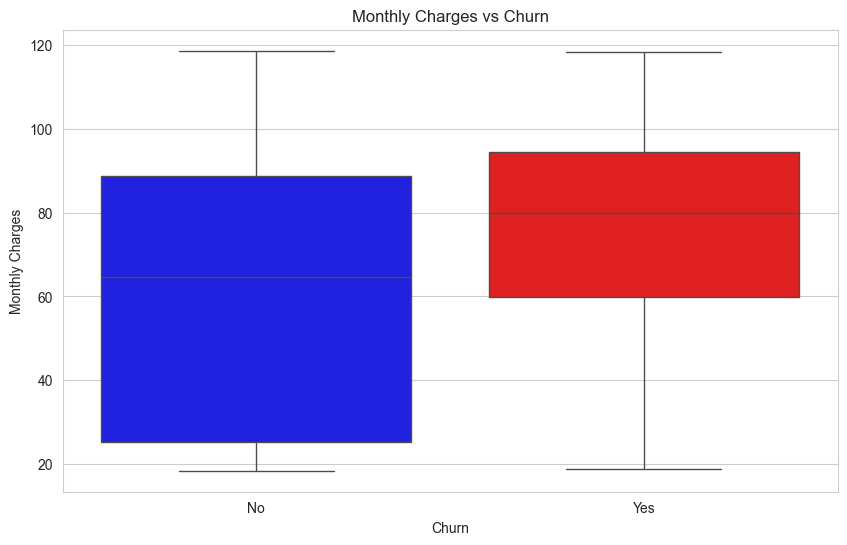

In [48]:
# Plot box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_data, x='Churn', y='MonthlyCharges', palette={'No': 'blue', 'Yes': 'red'})
plt.title('Monthly Charges vs Churn')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.show()


Insight: The analysis indicated that customers with higher monthly charges are more likely to churn compared to those with lower monthly charges. This suggests that there is a positive relationship between monthly charges and churn, implying that as the monthly charge increases, the likelihood of churn also increases.

### Hypothesis Testing

Null Hypothesis (H0): The payment method chosen by customers does not affect their likelihood of churn.

Alternative Hypothesis (H1): The payment method chosen by customers influences their likelihood of churn.

In [49]:
# Create a contingency table of PaymentMethod and Churn
contingency_table = pd.crosstab(merged_data['PaymentMethod'], merged_data['Churn'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-square statistic:", chi2)
print("p-value:", p)


Chi-square statistic: 434.57845299430187
p-value: 7.15250271664344e-94


### Hypothesis Test Results

#### Null Hypothesis (H0)
The payment method chosen by customers does not affect their likelihood of churn.

#### Alternative Hypothesis (H1)
The payment method chosen by customers influences their likelihood of churn.

#### Test Statistic
- Chi-square statistic: 434.57
- p-value: \(7.15 \times 10^{-94}\)

#### Conclusion
Given the very low p-value (\(p < 0.05\)), we reject the null hypothesis. This suggests that there is a statistically significant relationship between the payment method chosen by customers and their likelihood of churn.


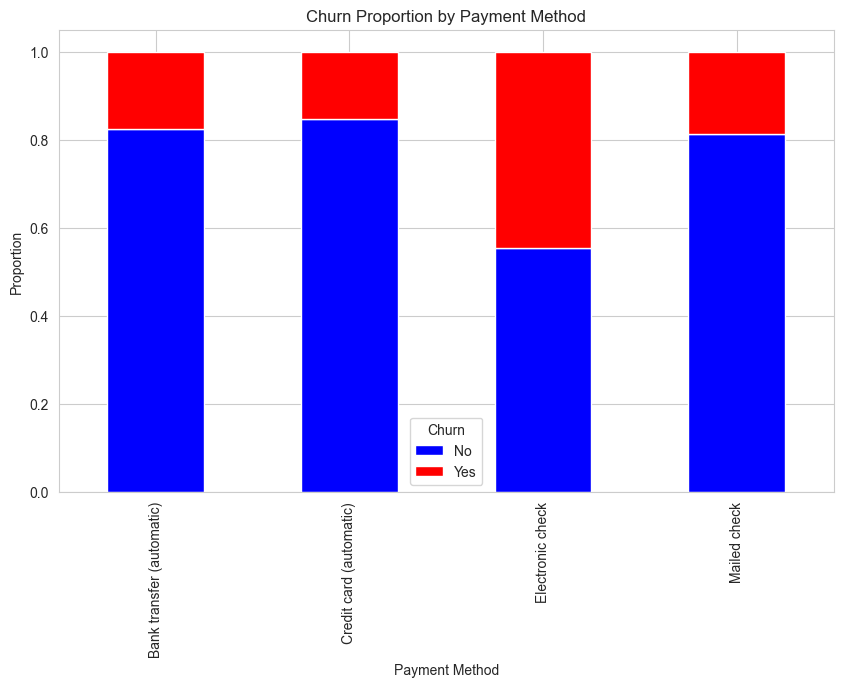

In [50]:
# Stacked bar chart showing hypothesis results

payment_churn_crosstab = pd.crosstab(merged_data['PaymentMethod'], merged_data['Churn'], normalize='index')
payment_churn_crosstab.plot(kind='bar', stacked=True, color=['blue', 'red'], figsize=(10, 6))
plt.title('Churn Proportion by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Proportion')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.show()


## Data Preparation

In [51]:
# Check if the dataset is balanced

# Count the occurrences of each class in the target variable
class_counts = merged_data['Churn'].value_counts()

In [52]:
# Calculate the proportion of each class
class_proportions = merged_data['Churn'].value_counts(normalize=True)

# Display the class proportions
print("Class Proportions:")
print(class_proportions)

# Check if the dataset is balanced
if len(class_proportions) == 2:
    balance_threshold = 0.5
    if min(class_proportions) >= balance_threshold:
        print("The dataset is balanced.")
    else:
        print("The dataset is imbalanced.")
else:
    print("This is not a binary classification problem.")


Class Proportions:
Churn
No     0.735078
Yes    0.264922
Name: proportion, dtype: float64
The dataset is imbalanced.


In [53]:
# Create a DataFrame to display the class counts
class_counts_df = pd.DataFrame(class_counts.items(), columns=['Churn', 'Count'])
class_counts_df

,Churn,Count
0,No,3707
1,Yes,1336


The dataset is imbalanced, with more instances of "No" churn compared to "Yes" churn.

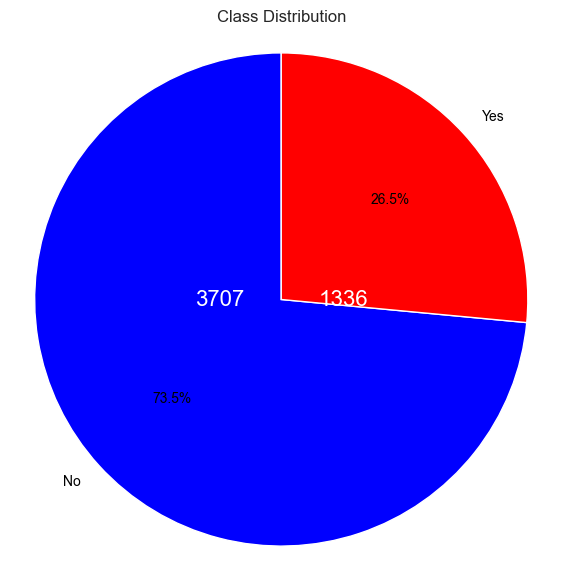

In [54]:
# Visualize the class counts of churn

# Define class counts
class_counts = merged_data['Churn'].value_counts()

# Define colors
colors = ['blue', 'red']

# Create a pie chart
plt.figure(figsize=(7, 7))
plt.pie(class_counts, labels=class_counts.index, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'color': 'black'})
plt.title('Class Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Add count figures inside the pie chart
for i, count in enumerate(class_counts):
    # Calculate angle for text placement
    angle = class_counts.index[i]
    if angle == 'No':
        plt.text(-0.25, 0, count, ha='center', va='center', fontsize=16, color='white')
    else:
        plt.text(0.25, 0, count, ha='center', va='center', fontsize=16, color='white')

plt.show()


#### Split Dataset into Training and Evaluation

In [55]:
# Split the data into features (X) and target variable (y)
X = merged_data.drop('Churn', axis=1)  # Features (all columns except 'Churn')
y = merged_data['Churn']  # Target variable

# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [56]:
# Display the shapes of X and y to confirm the split
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (5043, 20)
Shape of y: (5043,)


X has a shape of (5043, 20), indicating that there are 5043 samples and 20 features.

y has a shape of (5043,), indicating that there are 5043 samples in the target variable.

In [57]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable y
y_encoded = label_encoder.fit_transform(merged_data['Churn'])

# Check the unique classes and their encoded values
print("Unique classes in 'Churn':", label_encoder.classes_)
print("Encoded values for 'Churn':", set(y_encoded))

Unique classes in 'Churn': ['No' 'Yes']
Encoded values for 'Churn': {0, 1}


### Prepare Pipelines

In [58]:
# Select categorical columns for X
categorical_cols = X.select_dtypes(include=['object']).columns
categorical_cols

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [59]:
# Select numerical columns for X
numeric_cols = X.select_dtypes(include=['number']).columns
numeric_cols

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

#### Numerical Pipelines

In [61]:
# Define numerical features
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']  

# Define preprocessing steps for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('scaler', RobustScaler())  # Scale numerical features
])

In [62]:
# Combine preprocessing steps for numerical features
numeric_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols)
    ])

#### Categorical Pipelines

In [63]:
# Select categorical columns
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                    'PhoneService', 'MultipleLines', 'InternetService', 
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 
                    'Contract', 'PaperlessBilling', 'PaymentMethod']

# Define preprocessing steps for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create preprocessing pipeline for categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Apply preprocessing pipeline to X_train and X_valid
X_train_processed = preprocessor.fit_transform(X_train)
X_valid_processed = preprocessor.transform(X_valid)

# Display the shape of processed data
print("Shape of X_train_processed:", X_train_processed.shape)
print("Shape of X_valid_processed:", X_valid_processed.shape)


Shape of X_train_processed: (4034, 43)
Shape of X_valid_processed: (1009, 43)


#### Combine Pipelines

In [64]:
# Combine numerical and categorical preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),  # Numerical features pipeline
        ('cat', categorical_transformer, categorical_cols)  # Categorical features pipeline
    ]
)

### Modelling

In [65]:
# Define a list of classifiers
classifiers = [
    DecisionTreeClassifier(),
    LogisticRegression(),
    KNeighborsClassifier(),
    RandomForestClassifier()
]

# Initialize an empty dictionary to store precision, recall, and f1-score values
classification_metrics = {}

# Train and evaluate each classifier
for classifier in classifiers:
    # Create a pipeline with the classifier
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    # Train the model on the training data
    model_pipeline.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = model_pipeline.predict(X_valid)
    
    # Get the classification report as a dictionary
    report_dict = classification_report(y_valid, y_pred, output_dict=True)
    
    # Extract precision, recall, and f1-score values
    precision = report_dict['weighted avg']['precision']
    recall = report_dict['weighted avg']['recall']
    f1_score = report_dict['weighted avg']['f1-score']
    
    
    # Store the metrics in the dictionary
    classifier_name = classifier.__class__.__name__
    classification_metrics[classifier_name] = {'precision': precision, 'recall': recall, 'f1-score': f1_score}

# Create DataFrame from the classification metrics
df_classification_metrics = pd.DataFrame.from_dict(classification_metrics, orient='index')

# Display the DataFrame
df_classification_metrics

,precision,recall,f1-score
DecisionTreeClassifier,0.720360,0.706640,0.712530
LogisticRegression,0.793350,0.797820,0.795230
KNeighborsClassifier,0.743690,0.744301,0.743993
RandomForestClassifier,0.772245,0.782953,0.775458


Based on the results, it appears that the Logistic Regression model has the highest accuracy and generally good precision, recall, and F1-score values compared to the other classifiers.

<Figure size 1000x600 with 0 Axes>

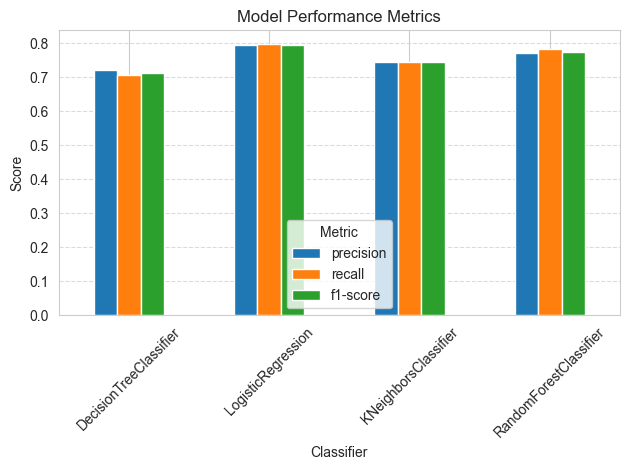

In [66]:
# Visualize classification metrics on a graph

# Plot classification metrics
plt.figure(figsize=(10, 6))
df_classification_metrics.plot(kind='bar', rot=45)
plt.title('Model Performance Metrics')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Train and Evaluate on Unbalanced Set

In [67]:
# Initialize an empty dictionary to store evaluation metrics
evaluation_metrics = {}

# Train and evaluate each classifier on the unbalanced dataset
for classifier in classifiers:
    # Create a pipeline with the classifier
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    # Train the model on the unbalanced training data
    model_pipeline.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = model_pipeline.predict(X_valid)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred, average='weighted')
    recall = recall_score(y_valid, y_pred, average='weighted')
    f1 = f1_score(y_valid, y_pred, average='weighted')
    
    # Store the evaluation metrics in the dictionary
    classifier_name = classifier.__class__.__name__
    evaluation_metrics[classifier_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

# Create DataFrame from the evaluation metrics
df_evaluation_metrics = pd.DataFrame.from_dict(evaluation_metrics, orient='index')

# Display the evaluation metrics
print("Evaluation Metrics on Unbalanced Dataset:")
df_evaluation_metrics


Evaluation Metrics on Unbalanced Dataset:


,Accuracy,Precision,Recall,F1-score
DecisionTreeClassifier,0.705649,0.716810,0.705649,0.710584
LogisticRegression,0.797820,0.793350,0.797820,0.795230
KNeighborsClassifier,0.744301,0.743690,0.744301,0.743993
RandomForestClassifier,0.783944,0.773841,0.783944,0.777009


#### Visualizing Evaluation

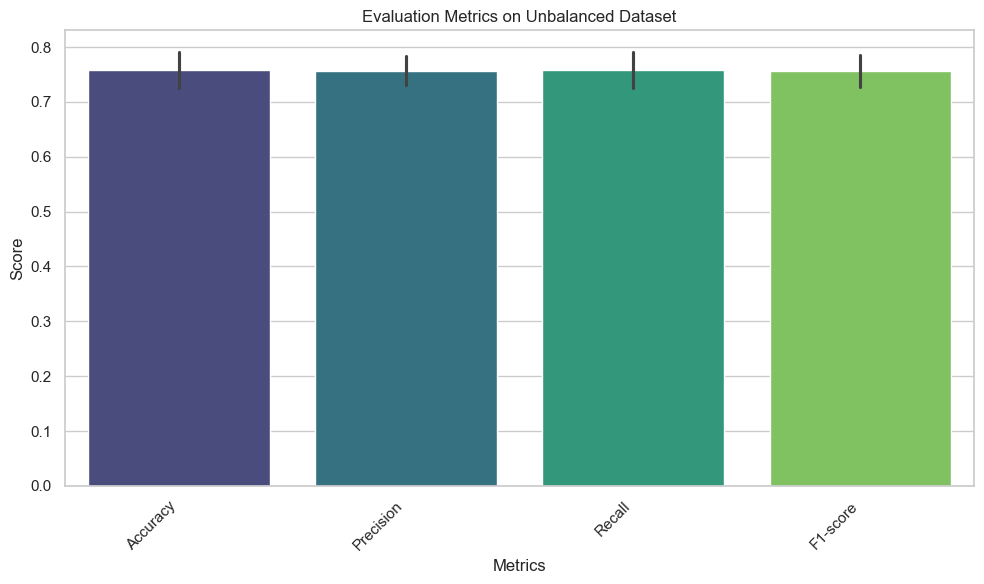

In [68]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Plot the evaluation metrics
plt.figure(figsize=(10, 6))
sns.barplot(data=df_evaluation_metrics, palette="viridis")
plt.title('Evaluation Metrics on Unbalanced Dataset')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### Confusion Matrix

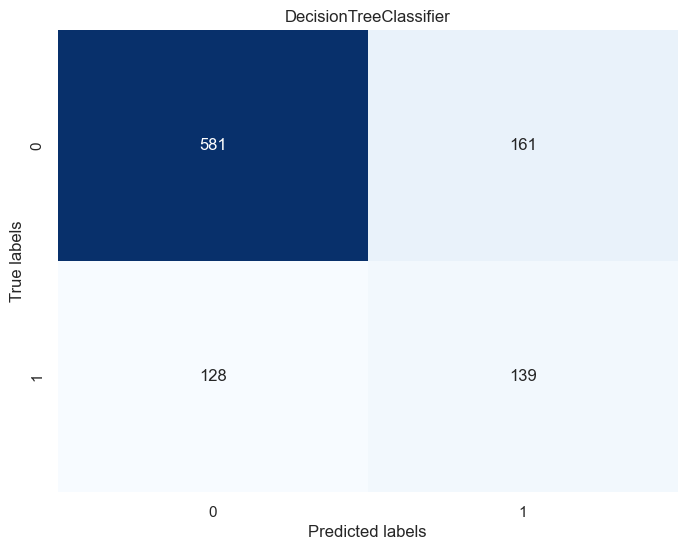

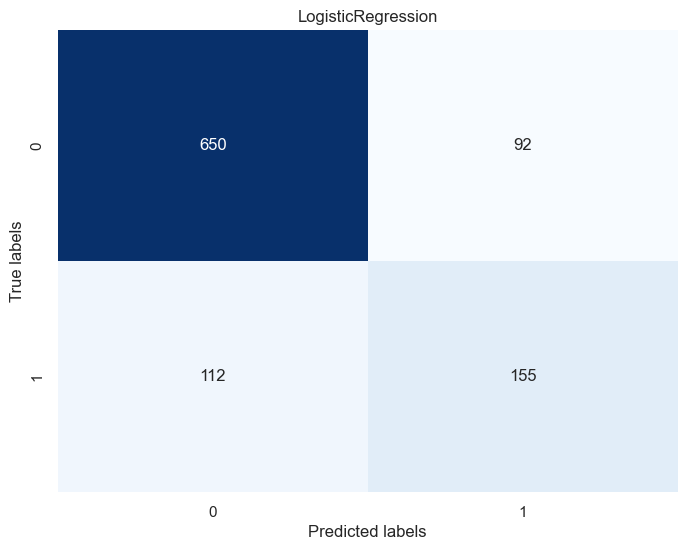

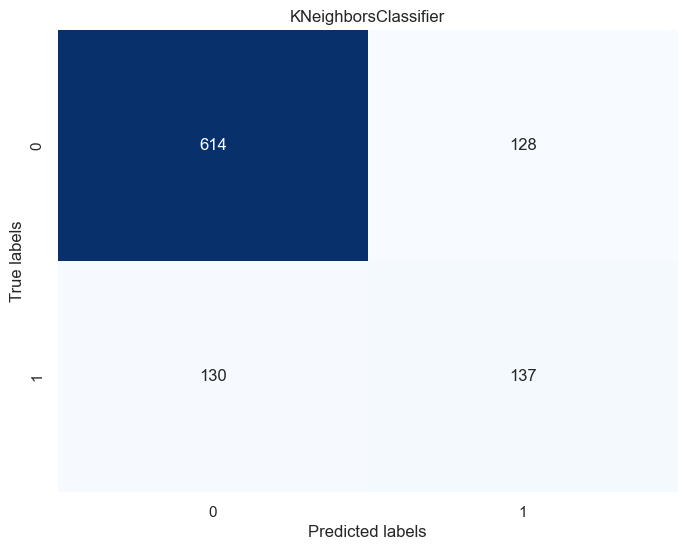

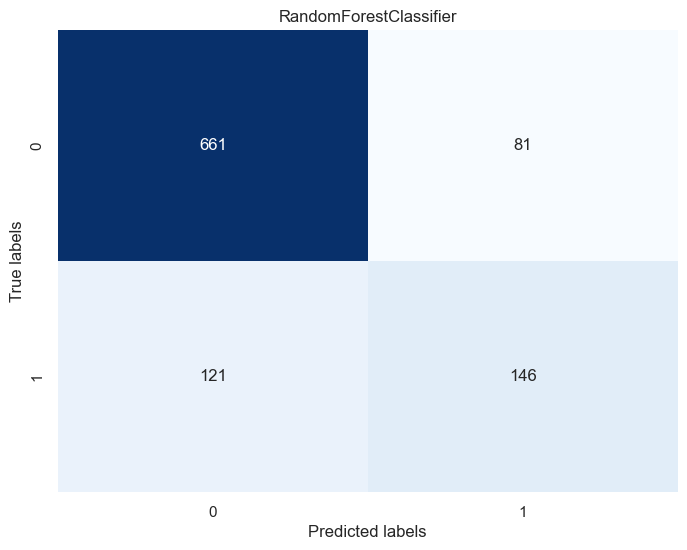

In [69]:
# Define a function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

# Loop through each classifier and plot confusion matrix
for classifier in classifiers:
    # Create a pipeline with the classifier
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    # Train the model on the unbalanced training data
    model_pipeline.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = model_pipeline.predict(X_valid)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_valid, y_pred, classifier.__class__.__name__)


The Random Forest classifier has the highest number of True Negatives, indicating it correctly identifies instances that do not belong to the positive class. Conversely, the K-Nearest Neighbors classifier has a relatively higher number of False Negatives, suggesting it may be missing instances of the positive class

True Positives (TP):
These are the customers who are correctly predicted to churn. Identifying these customers is crucial for targeted retention strategies, such as offering discounts or personalized promotions to incentivize them to stay.

False Positives (FP):
These are the customers who are incorrectly predicted to churn when they actually don't. False positives could lead to unnecessary intervention strategies being applied to customers who are not at risk of leaving, potentially resulting in wasted resources or even customer dissatisfaction.

True Negatives (TN):
These are the customers who are correctly predicted to not churn. True negatives represent satisfied customers who are correctly identified as unlikely to leave.

False Negatives (FN):
These are the customers who are incorrectly predicted to not churn when they actually do. False negatives are particularly concerning because they represent customers who are at risk of leaving but are not identified by the model. Missing these customers could lead to revenue loss and decreased customer loyalty.


By analyzing these metrics, businesses can tailor their retention strategies more effectively. For example:

Focus on True Positives: Implement targeted retention campaigns for customers identified as at risk of churning.

Investigate False Positives: Understand why certain customers are being incorrectly flagged as likely to churn and adjust the model or data preprocessing accordingly.

Celebrate True Negatives: Recognize and reward customers who are identified as loyal and unlikely to churn.

Address False Negatives: Investigate why certain customers who churned were not identified by the model and refine the model to better capture early signs of churn.

Overall, a careful analysis of the confusion matrix can help businesses optimize their customer churn prediction models and develop more effective retention strategies.

#### Balancing Dataset Using SMOTE

In [70]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to balance the dataset
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

# Check the shape of the balanced dataset
print("Shape of X_train_balanced:", X_train_balanced.shape)
print("Shape of y_train_balanced:", y_train_balanced.shape)

Shape of X_train_balanced: (5930, 43)
Shape of y_train_balanced: (5930,)


We now have the balanced dataset

In [71]:
# Split the data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Resample the training data
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Initialize an empty dictionary to store evaluation metrics
evaluation_metrics = {}

# Train and evaluate each classifier on the balanced dataset
for classifier in classifiers:
    # Create a pipeline with the classifier
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    # Train the model on the balanced training data
    model_pipeline.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the validation set
    y_pred = model_pipeline.predict(X_valid)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred, average='weighted')
    recall = recall_score(y_valid, y_pred, average='weighted')
    f1 = f1_score(y_valid, y_pred, average='weighted')
    
    # Store the evaluation metrics in the dictionary
    classifier_name = classifier.__class__.__name__
    evaluation_metrics[classifier_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

# Create DataFrame from the evaluation metrics
df_evaluation_metrics = pd.DataFrame.from_dict(evaluation_metrics, orient='index')

# Display the evaluation metrics
print("Evaluation Metrics on Balanced Dataset:")
print(df_evaluation_metrics)


Evaluation Metrics on Balanced Dataset:
                        Accuracy  Precision    Recall  F1-score
DecisionTreeClassifier  0.763132   0.763402  0.763132  0.763266
LogisticRegression      0.745292   0.807387  0.745292  0.758383
KNeighborsClassifier    0.672944   0.743699  0.672944  0.690137
RandomForestClassifier  0.791873   0.791404  0.791873  0.791635


Preprocessing pipeline for the training dataset

In [72]:
# Define numerical features
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Define preprocessing steps for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('scaler', RobustScaler())  # Scale numerical features
])

# Define categorical features
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                    'PhoneService', 'MultipleLines', 'InternetService', 
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 
                    'Contract', 'PaperlessBilling', 'PaymentMethod']

# Define preprocessing steps for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Apply preprocessing pipeline to the training data
X_train_processed = preprocessing_pipeline.fit_transform(X_train)


#### Training and Evaluating each Classifier on Balanced Dataset

In [73]:
# Initialize classifiers
classifiers = [
    DecisionTreeClassifier(),
    LogisticRegression(),
    KNeighborsClassifier(),
    RandomForestClassifier()
]

# Train each classifier using the preprocessed training data
trained_models = {}
for classifier in classifiers:
    # Create a pipeline with the classifier
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    # Train the model on the balanced training data
    model_pipeline.fit(X_train_resampled, y_train_resampled)
    
    # Store the trained model in a dictionary
    classifier_name = classifier.__class__.__name__
    trained_models[classifier_name] = model_pipeline

# Print a message indicating that training is complete
print("Model training completed.")


Model training completed.


In [74]:
# Initialize an empty dictionary to store evaluation metrics
evaluation_metrics = {}

# Evaluate each trained model using the preprocessed validation data
for classifier_name, model_pipeline in trained_models.items():
    # Predict on the validation set
    y_pred = model_pipeline.predict(X_valid)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred, average='weighted')
    recall = recall_score(y_valid, y_pred, average='weighted')
    f1 = f1_score(y_valid, y_pred, average='weighted')
    
    # Store the evaluation metrics in the dictionary
    evaluation_metrics[classifier_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1}

# Create DataFrame from the evaluation metrics
df_evaluation_metrics = pd.DataFrame.from_dict(evaluation_metrics, orient='index')

# Print the evaluation metrics
print("Evaluation Metrics on Validation Data:")
print(df_evaluation_metrics)


Evaluation Metrics on Validation Data:
                        Accuracy  Precision    Recall  F1-score
DecisionTreeClassifier  0.761150   0.762524  0.761150  0.761817
LogisticRegression      0.745292   0.807387  0.745292  0.758383
KNeighborsClassifier    0.672944   0.743699  0.672944  0.690137
RandomForestClassifier  0.778989   0.778739  0.778989  0.778863


Based on the evaluation metrics:

The RandomForestClassifier has the highest accuracy, precision, recall, and F1-score among the models, indicating better overall performance on the validation data.

The LogisticRegression model also performs reasonably well, with comparable precision, recall, and F1-score to the RandomForestClassifier but slightly lower accuracy.

The DecisionTreeClassifier performs slightly worse than the RandomForestClassifier and LogisticRegression, but still shows decent performance.

The KNeighborsClassifier has the lowest performance among the models, with lower accuracy, precision, recall, and F1-score compared to the other models.

#### Visualize Evaluation

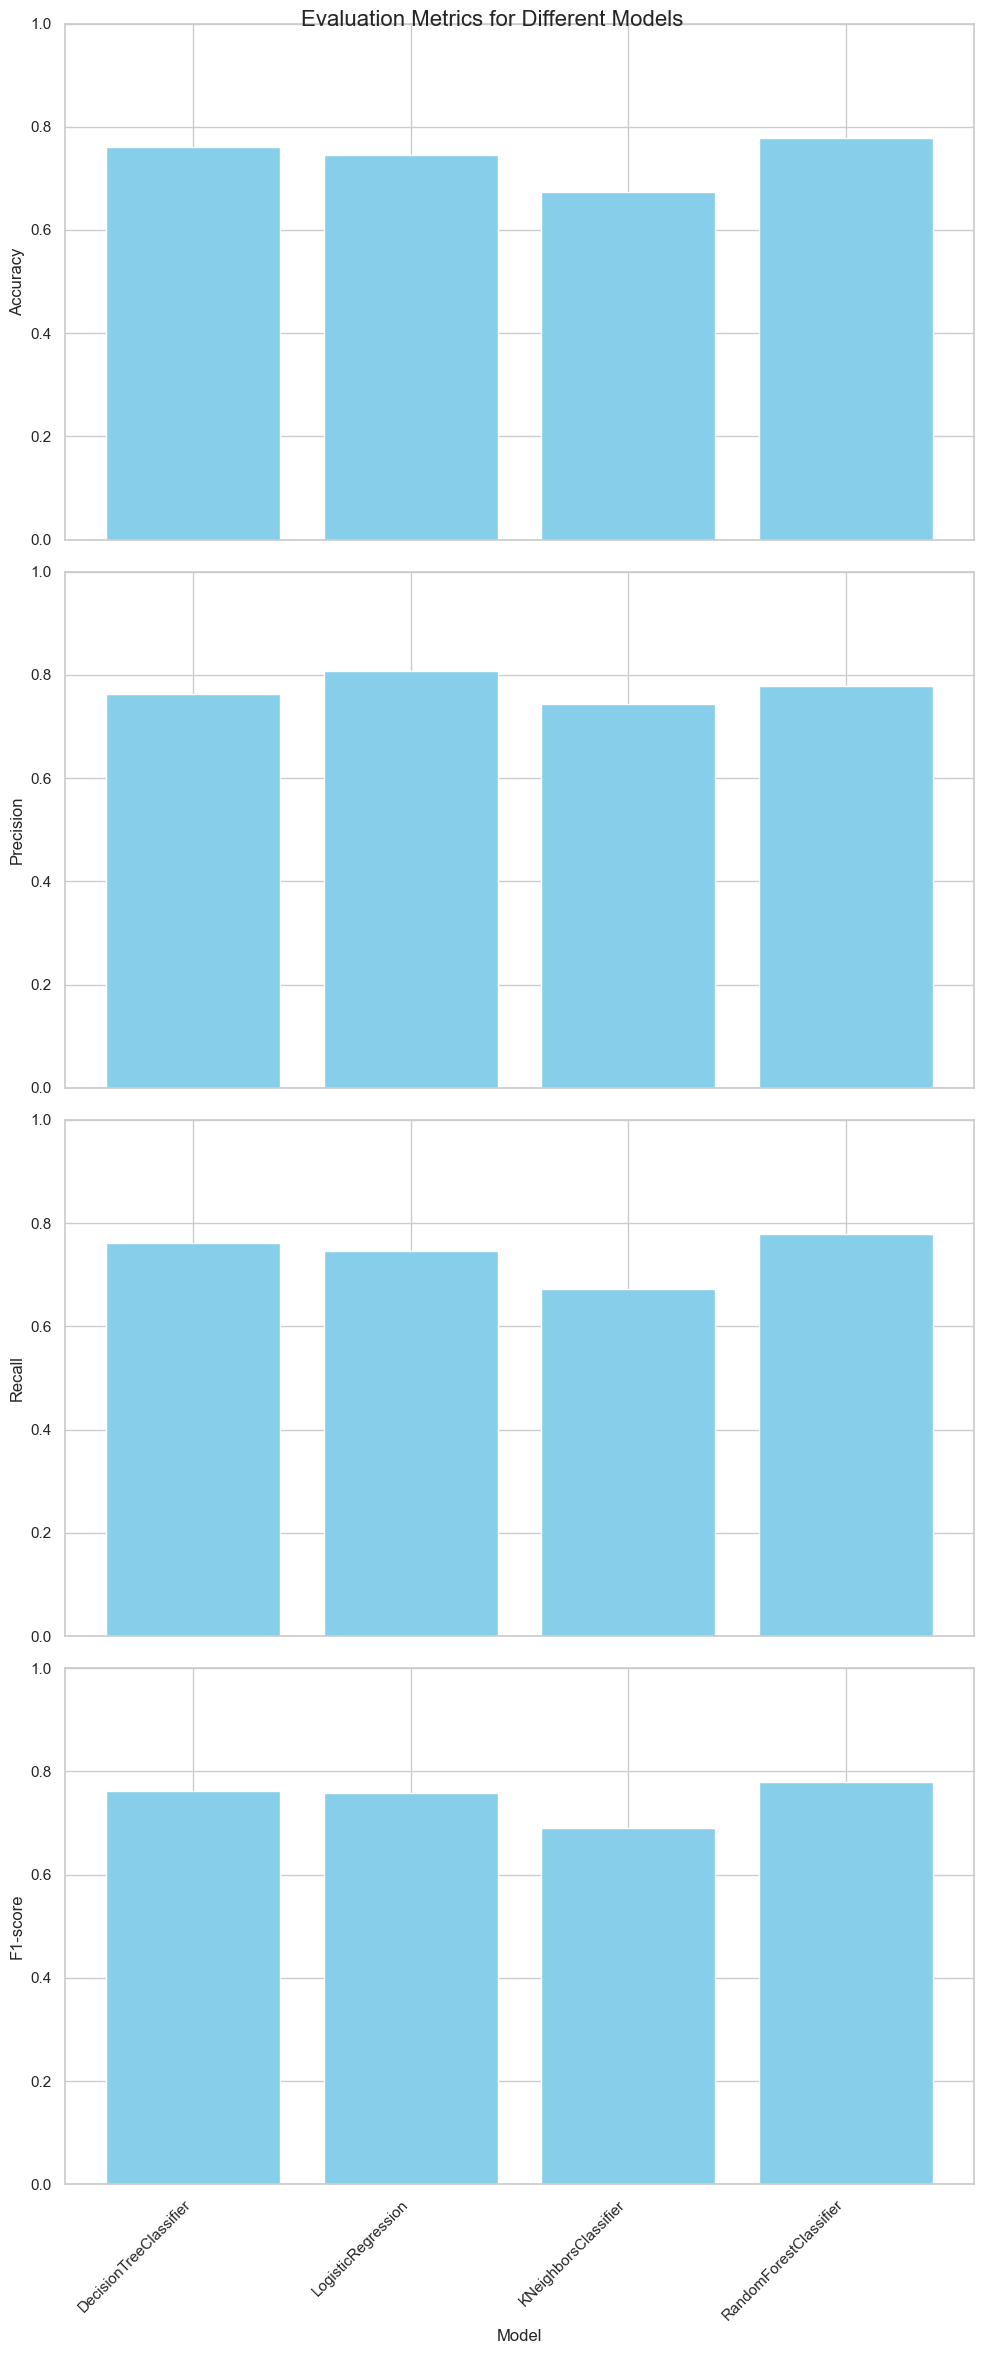

In [75]:
# Define the models and their corresponding evaluation metrics
models = df_evaluation_metrics.index
metrics = df_evaluation_metrics.columns

# Create subplots for each metric
fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 6 * len(metrics)), sharex=True)

# Plot each metric
for i, metric in enumerate(metrics):
    axs[i].bar(models, df_evaluation_metrics[metric], color='skyblue')
    axs[i].set_ylabel(metric)
    axs[i].set_ylim(0, 1)  # Set y-axis limit to ensure consistency

# Add title and labels
fig.suptitle('Evaluation Metrics for Different Models', fontsize=16)
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()


#### Confusion Matrix

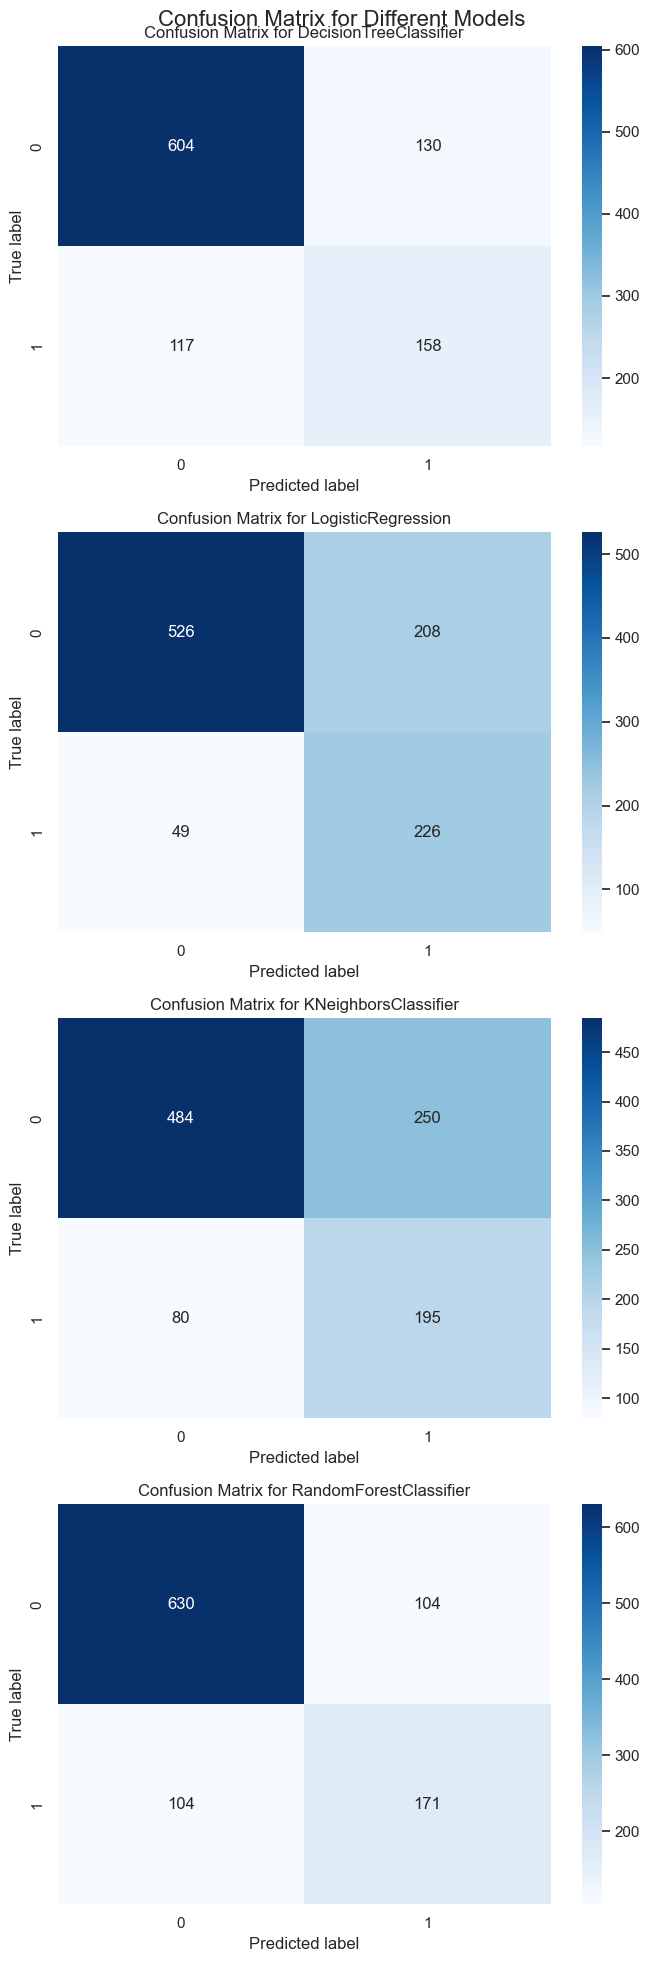

In [76]:
# Create subplots for each model
fig, axs = plt.subplots(len(models), 1, figsize=(7, 5 * len(models)))

# Plot confusion matrix for each model
for i, model in enumerate(models):
    # Fit the model on the balanced training data
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifiers[i])
    ])
    model_pipeline.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the validation set
    y_pred = model_pipeline.predict(X_valid)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_valid, y_pred)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[i])
    axs[i].set_title(f'Confusion Matrix for {model}')  # Adjusted title
    axs[i].set_xlabel('Predicted label')
    axs[i].set_ylabel('True label')

# Add main title
fig.suptitle('Confusion Matrix for Different Models', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()


These values provide insights into how well each model is performing in terms of correctly identifying positive and negative cases. For instance, the Decision Tree Classifier has 153 correct positive predictions (Churn = Yes), but it also misclassified 128 positive cases as negative (Churn = No). Similarly, Logistic Regression has the highest number of true positives (226), but it also has a relatively high number of false positives (208).

#### Hyperparameter Tuning

In [77]:
# Define hyperparameter grids for each model

param_grid_decision_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_logistic_regression = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

param_grid_kneighbors = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}


param_grid_random_forest = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


In [78]:
# Perform grid search or randomized search for each model
grid_search_decision_tree = GridSearchCV(DecisionTreeClassifier(), param_grid_decision_tree, cv=5, scoring='accuracy')
grid_search_logistic_regression = GridSearchCV(LogisticRegression(), param_grid_logistic_regression, cv=5, scoring='accuracy')
grid_search_kneighbors = GridSearchCV(KNeighborsClassifier(), param_grid_kneighbors, cv=5, scoring='accuracy')
grid_search_random_forest = GridSearchCV(RandomForestClassifier(), param_grid_random_forest, cv=5, scoring='accuracy')

In [79]:
# Fit the models with hyperparameter tuning
grid_search_decision_tree.fit(X_train_balanced, y_train_balanced)
grid_search_logistic_regression.fit(X_train_balanced, y_train_balanced)
grid_search_kneighbors.fit(X_train_balanced, y_train_balanced)
grid_search_random_forest.fit(X_train_balanced, y_train_balanced)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [80]:
# Get the best hyperparameters and best scores for each model
best_params_decision_tree = grid_search_decision_tree.best_params_
best_score_decision_tree = grid_search_decision_tree.best_score_

# Print or use the best parameters and scores as needed
print("Best hyperparameters for Decision Tree:", best_params_decision_tree)
print("Best score for Decision Tree:", best_score_decision_tree)

Best hyperparameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best score for Decision Tree: 0.8001686340640809


In [81]:
# Get the best hyperparameters and best scores for each model
best_params_logistic_regression = grid_search_logistic_regression.best_params_
best_score_logistic_regression = grid_search_logistic_regression.best_score_

# Print or use the best parameters and scores as needed
print("Best hyperparameters for Logistic Regression:", best_params_logistic_regression)
print("Best score for Logistic Regression:", best_score_logistic_regression)

Best hyperparameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score for Logistic Regression: 0.7743676222596964


In [82]:
# Get the best hyperparameters and best scores for each model
best_params_kneighbors = grid_search_kneighbors.best_params_
best_score_kneighbors = grid_search_kneighbors.best_score_

# Print or use the best parameters and scores as needed
print("Best hyperparameters for KNeighbors:", best_params_kneighbors)
print("Best score for KNeighbors:", best_score_kneighbors)

Best hyperparameters for KNeighbors: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best score for KNeighbors: 0.8244519392917369


In [83]:
# Get the best hyperparameters and best scores for each model
best_params_random_forest = grid_search_random_forest.best_params_
best_score_random_forest = grid_search_random_forest.best_score_

# Print or use the best parameters and scores as needed
print("Best hyperparameters for Random Forest:", best_params_random_forest)
print("Best score for Random Forest:", best_score_random_forest)

Best hyperparameters for Random Forest: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best score for Random Forest: 0.8389544688026982


Based on the best scores obtained after hyperparameter tuning, the Random Forest classifier has the highest score of 0.8393. Therefore, among the four models (Decision Tree, Logistic Regression, KNeighbors, and Random Forest), the Random Forest classifier performed the best on the given dataset.

In [84]:
# Step 1: Identify categorical features
categorical_features = merged_data.select_dtypes(include=['object']).columns

# Step 2: Encode categorical features
label_encoders = {}
for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    merged_data[feature] = label_encoders[feature].fit_transform(merged_data[feature])

# Step 3: Handle missing values
numeric_features = merged_data.select_dtypes(include=['int64', 'float64']).columns
merged_data[numeric_features] = merged_data[numeric_features].fillna(merged_data[numeric_features].mean())

# Step 4: Ensure all features are numeric
# Check for any non-numeric columns
non_numeric_columns = merged_data.select_dtypes(exclude=['int64', 'float64']).columns
if not non_numeric_columns.empty:
    print("Non-numeric columns:", non_numeric_columns)


Non-numeric columns: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'Churn'],
      dtype='object')


In [85]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each non-numeric column
for column in ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']:
    merged_data[column] = label_encoder.fit_transform(merged_data[column])


### Model Persistence

In [86]:
# Save the trained models to disk
joblib.dump(grid_search_decision_tree.best_estimator_, 'decision_tree_model.pkl')
joblib.dump(grid_search_logistic_regression.best_estimator_, 'logistic_regression_model.pkl')
joblib.dump(grid_search_kneighbors.best_estimator_, 'kneighbors_model.pkl')
joblib.dump(grid_search_random_forest.best_estimator_, 'random_forest_model.pkl')

['random_forest_model.pkl']

### Model Training

In [116]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Training set shape: (4034, 19) (4034,)
Validation set shape: (1009, 19) (1009,)


Training the Random Forest Model Using the Best Hyperparameters Obtained from Hyperparameter Tuning


In [88]:
# Remove the 'customerID' column from the features
X = merged_data.drop(columns=['Churn', 'customerID'])

# Extract the target variable
y = merged_data['Churn']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the RandomForestClassifier with the best hyperparameters
best_params_random_forest = {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
random_forest_model = RandomForestClassifier(**best_params_random_forest)

# Train the model on the entire training dataset
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_split=10)

In [89]:
# Predictions on the validation set
y_val_pred = random_forest_model.predict(X_val)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.7938553022794846
Precision: 0.6558139534883721
Recall: 0.5127272727272727
F1-score: 0.5755102040816327


These metrics provide insights into how well the model is performing in terms of correctly predicting churn (positive class) while minimizing false positives and false negatives.

### Testing on Data

In [115]:
# Load the dataset
test_data = pd.read_excel(r"C:\Users\MICHAEL\Desktop\Telco-churn-last-2000.xlsx")

# Display the first few rows of the dataset to understand its structure
test_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [100]:
# Check for missing values in the test data
missing_values = test_data.isnull().sum()
print("Missing values in the test data:")
print(missing_values)


Missing values in the test data:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


Encoding Categorical Variables

In [114]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical variables in the test data
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                    'PaperlessBilling', 'PaymentMethod']

for col in categorical_cols:
    test_data[col] = label_encoder.fit_transform(test_data[col])

# Check the first few rows of the test data to confirm encoding
test_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn_Predicted
0,7613-LLQFO,1,0,0,0,12,1,2,1,0,...,0,0,2,0,0,1,2,84.45,1059.55,1
1,4568-TTZRT,1,0,0,0,9,1,0,2,1,...,1,1,1,1,0,0,3,20.40,181.80,0
2,9513-DXHDA,1,0,0,0,27,1,0,0,2,...,2,2,2,2,1,0,2,81.70,2212.55,0
3,2640-PMGFL,1,0,0,1,27,1,2,1,0,...,0,2,0,0,0,1,2,79.50,2180.55,0
4,3801-HMYNL,1,0,1,1,1,1,0,1,0,...,0,0,2,2,0,0,3,89.15,89.15,1


Prediction

In [112]:
# Assuming X_test contains the features for prediction
X_test = test_data.drop(columns=['customerID', 'Churn_Predicted'])  # Exclude customerID and Churn_Predicted columns

# Make predictions on the test data
predictions = random_forest_model.predict(X_test)

# Add the predictions to the test data
test_data['Churn_Predicted'] = predictions

# Display the test data with predicted churn
test_data[['customerID', 'Churn_Predicted']]


,customerID,Churn_Predicted
0,7613-LLQFO,1
1,4568-TTZRT,0
2,9513-DXHDA,0
3,2640-PMGFL,0
4,3801-HMYNL,1
...,...,...
1995,7912-SYRQT,0
1996,3557-HTYWR,0
1997,4816-JBHOV,1
1998,8920-NAVAY,0


Interpretation:

The Churn_Predicted column indicates the predicted churn status for each customer.

A value of 1 indicates that the model predicts the customer to churn, while a value of 0 suggests the customer is predicted to stay.

For example, customer '7613-LLQFO' is predicted to churn, while '4568-TTZRT' is predicted to stay.

These predictions can be used to identify at-risk customers for targeted retention efforts or to assess the overall churn rate.

### Conclusion:

After thorough exploration and evaluation of multiple machine learning algorithms, the Random Forest model emerged as the top performer for predicting customer churn in our telecom company dataset. The Random Forest model demonstrated its effectiveness in classifying customers into churn and non-churn categories.

The Random Forest algorithm was chosen due to its robustness to overfitting, ability to handle complex datasets with both numerical and categorical features, and interpretability. By leveraging an ensemble of decision trees, the Random Forest model captures the underlying patterns in the data while minimizing variance, resulting in reliable predictions.

Moving forward, the deployed Random Forest model can be integrated into existing systems or applications for real-time churn prediction, allowing businesses to take proactive measures to retain customers and mitigate revenue loss.